In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('/data/alpha-transform'))
if module_path not in sys.path:
    sys.path.append(module_path)
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #"0" for the 1st GPU or "1" to use the 2nd

In [2]:
#%%DATA INITIALIZATION
import numpy as np
from AlphaTransform import AlphaShearletTransform as AST
import shape_constraint.cadmos_lib as cl
import os


row,column = np.array([96,96])
U = cl.makeUi(row,column)

# Get shearlet elements
#Step 1 : create a shearlet transform instance
trafo = AST(column, row, [0.5]*3,real=True,parseval=True,verbose=False)
#Step 2 : get shearlets filters
shearlets = trafo.shearlets
#Step 3 : get the adjoints
adjoints = cl.get_adjoint_coeff(trafo)

#Normalize shearlets filter banks
#/!\ The order is important/!\
adjoints = cl.shear_norm(adjoints,shearlets)
shearlets = cl.shear_norm(shearlets,shearlets)

#Compute moments constraint normalization coefficients
#the $\Psi^*_j$ are noted adj_U
adj_U = cl.comp_adj(U,adjoints)
print(adj_U.shape[-1])
mu = cl.comp_mu(adj_U)
adj_U=adj_U.reshape(6,27,1,96,96,1)

/home/cben-ali/Programs/deep-deconv/python/shape_constraint/cadmos_lib.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


96


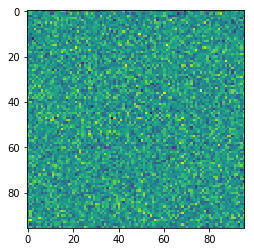

In [16]:
import matplotlib.pyplot as plt
import keras.backend as K
residual=K.variable(np.random.randn(96,96))
plt.imshow(K.eval(residual))

In [21]:
temp=0
for i in range(6):
    for j in range(27):
        temp+=mu[i,j]*K.square(K.sum(residual*adj_U[i,j],axis=(1,2,3)))
temp/=(96*96)
K.eval(temp)        


array([3474.443], dtype=float32)

In [14]:
np.array(temp).sum()


0.023265691

In [5]:
residual*adj_U[0,0]

<tf.Tensor 'mul_324:0' shape=(1, 96, 96, 96) dtype=float32>

In [22]:
K.eval(K.mean(K.square(residual)))

0.9933431

In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.75 

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

Using TensorFlow backend.


In [58]:
U=makeUi(96,96)
gamma=1
x=np.zeros((96,96,1))
W=np.zeros((96,96,1))
W[40:56,40:56,0]=1

ntest=1000

mu=np.array([np.size(W)/np.linalg.norm((W*Ui).reshape((96,96)))**2/U.shape[0] for Ui in U])
#mu=np.array([np.size(W)/np.linalg.norm(W*(Ui.reshape((96,96))))**2/U.shape[0] for Ui in U])

Mtot=np.zeros((ntest,7))
for k in range(ntest):
    y=np.random.randn(96,96,1)
    for i in range(6):
        Mtot[k,i]=(gamma*mu[i]*(((y-x)*W*U[i]).sum()**2)/2)
    Mtot[k,6]=np.linalg.norm(y-x)**2/2


In [61]:
Mmean=np.mean(Mtot,axis=0)
print(np.sum(Mmean[0:6]),Mmean[6])

4790.093628004028 4608.991516826983


(<matplotlib.image.AxesImage at 0x7f7bb04e57f0>,
 <matplotlib.colorbar.Colorbar at 0x7f7bb0495160>)

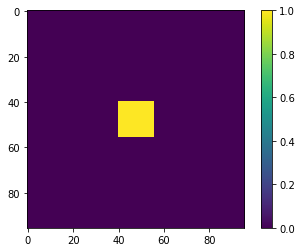

In [38]:
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(U[2])*W),plt.colorbar()

In [18]:
from simplify_attempt.DeepNet_simplify import makeUi   
import numpy as np
import keras.backend as K

U=makeUi(96,96)
gamma=1
y=np.random.randn(96,96)
x=np.zeros((96,96))
W=np.zeros((96,96))
W[30:66,30:66]=1
mu=np.array([len(W)/np.linalg.norm(W*(Ui.reshape((96,96))))**2/U.shape[0] for Ui in U])

M=0
for i in range(6):
    M+=gamma*mu[i]*(((y-x)*W*U[i]).sum()**2)/2
    print(M)

m=np.array([len(W)/np.linalg.norm(W*(Ui.reshape((96,96))))**2/U.shape[0] for Ui in U])

#print(x,y,W,m,gamma)

for i in range(6):
    Mse+=(((((x-y)*W*(U[i].reshape(5,5))).sum())**2)/2*m[i])*gamma
print(Mse)

y=np.reshape(y,(1,5,5,1))
x=np.reshape(x,(1,5,5,1))
#window=K.variable(window)
W1=W1.reshape((2,5,5,1))


def shape_loss(y_true,y_pred):
    residual=K.variable(y_true-y_pred,dtype=float)
    M=K.eval(K.mean(K.square(residual), axis=-1)).mean()
    window=K.variable(W)
    mu=K.variable(m)
    print(residual,mu,window)
    for i in range(6):
        M+=gamma*K.eval(mu[:,i,:,:])*((K.eval((residual)*window*U[i])).sum()**2)/2
    M=K.variable(np.ones((96,96)))*M 
    print("MSE+SHAPE",K.int_shape(M))
    return M

def shape_loss_tensor(y_true,y_pred):
    residual=K.variable(y_true-y_pred,dtype=float)
    residual=K.reshape(residual,(2,5,5,1))
    M=K.mean(K.square(residual),axis=-1)
    window=K.variable(W1)
    mu=K.variable(m1)
    temp=0
    for i in range(6):
        temp+=gamma*mu[:,i,0,0]*(K.square((K.sum((residual)*window*U[i],axis=(1,2,3)))))/2
    #for i in range(K.int_shape(temp)[0]):
        #M[i,:,:]=M[i,:,:]+temp[i]
    temp=K.expand_dims((K.expand_dims(temp, axis=-1)),axis=-1)
    print("SHAPE",K.int_shape(M),K.int_shape(temp))
    #print(K.eval(M[0,:,:]+temp[0]))
    return M+temp




11648.205568028496
17998.479500318303
30203.819923770527
39370.2837001152
58909.293441895745
64969.69762648323


ValueError: cannot reshape array of size 9216 into shape (5,5)

In [5]:
K.variable(np.array((x,x)))


<tf.Variable 'Variable_1:0' shape=(2, 1, 5, 5, 1) dtype=float32_ref>

In [217]:
W=np.array([[0,0,0,0,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,0,0,0,0]])
y=np.array([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]])
x=np.array([[0,0,0,0,0],[0,1,2,1,0],[0,1,2,1,0],[0,1,2,1,0],[0,0,0,0,0]])
m=np.array([len(W)/np.linalg.norm(W*(Ui.reshape((5,5))))**2/U.shape[0] for Ui in U])
m=np.reshape(m,(1,6,1,1))
m
((x-y)*W*U[0].reshape(5,5)).sum()**2/2*m[:,0,:,:]

array([[[8.92857143]]])

In [4]:
from keras.engine.training_utils import weighted_masked_objective
import keras.losses as losses
weighted_loss2 = weighted_masked_objective(losses.get('mse'))
weighted_loss = weighted_masked_objective(shape_loss_tensor)
print(K.eval(shape_loss_tensor(K.variable(np.array((x,x))),K.variable(np.array((y,y))))))
print(K.eval(weighted_loss(K.variable(np.array((x,x))),
                               K.variable(np.array((y,y))),
                               None,
                               None)))
print(K.eval(weighted_loss2(K.variable(np.array((x,x))),
                               K.variable(np.array((y,y))),None,None)))
print(K.eval(losses.mean_squared_error(K.variable(np.array((x,x))),
                               K.variable(np.array((y,y))))))

SHAPE (2, 5, 5) (2, 1, 1)
[[[57.37585  60.37585  65.375854 72.375854 81.375854]
  [57.37585  57.37585  57.37585  65.375854 81.375854]
  [57.37585  57.37585  57.37585  65.375854 81.375854]
  [57.37585  57.37585  57.37585  65.375854 81.375854]
  [57.37585  60.37585  65.375854 72.375854 81.375854]]

 [[57.37585  60.37585  65.375854 72.375854 81.375854]
  [57.37585  57.37585  57.37585  65.375854 81.375854]
  [57.37585  57.37585  57.37585  65.375854 81.375854]
  [57.37585  57.37585  57.37585  65.375854 81.375854]
  [57.37585  60.37585  65.375854 72.375854 81.375854]]]
SHAPE (2, 5, 5) (2, 1, 1)
65.21585
8.84
[[[[ 1.  4.  9. 16. 25.]
   [ 1.  1.  1.  9. 25.]
   [ 1.  1.  1.  9. 25.]
   [ 1.  1.  1.  9. 25.]
   [ 1.  4.  9. 16. 25.]]]


 [[[ 1.  4.  9. 16. 25.]
   [ 1.  1.  1.  9. 25.]
   [ 1.  1.  1.  9. 25.]
   [ 1.  1.  1.  9. 25.]
   [ 1.  4.  9. 16. 25.]]]]


In [255]:
shape_loss(K.variable(x),K.variable(y))

<tf.Variable 'Variable_674:0' shape=(1, 5, 5, 1) dtype=float32_ref> <tf.Variable 'Variable_676:0' shape=(1, 6, 1, 1) dtype=float32_ref> <tf.Variable 'Variable_675:0' shape=(1, 5, 5, 1) dtype=float32_ref>
MSE+SHAPE (1, 5, 5)


<tf.Tensor 'mul_1518:0' shape=(1, 5, 5) dtype=float32>